# Alternative cleavage site usage between PABPN1 mutants

In [343]:
###Load Packages

#Functions for polyA specific analysis (must be in same path)
from polyA_utils import *

#Packages for general column manipulation and statistics
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from scipy import stats
import scipy.stats as sci
import pysam
from scipy.signal import find_peaks
import gffutils

#Packages for plotting
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")

Alternative cleavage site usage analyses for short read data were perfored using QAPA. Load in results dataframes for visualization. Compare 4SA vs 4SD (4SD set to reference condition)

In [344]:
#Set datapath for DESeq2 analyses
path = "/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp27_PABPN1_mutants_diffExp/Data_processing/results/apa/"

In [345]:
#Define a function to calculate differences in PAS usage between conditions
def APA_differences(df, condition1, condition2):
    test_stat_list = []
    df_2 = pd.DataFrame(df)
    c1_df = df_2.filter(regex="PAU").filter(regex=condition1)
    c2_df = df_2.filter(regex="PAU").filter(regex=condition2)
    for idx, i in c1_df.iterrows():
        c1_values = i.values.tolist()
        c2_values = c2_df.iloc[idx].values.tolist()
        test_stat = stats.ttest_ind(c1_values, c2_values).pvalue
        test_stat_list.append(test_stat)
    df_2[condition1 + "_PAU_mean"] = df_2.filter(regex="PAU").filter(regex=condition1).mean(axis=1)
    df_2[condition2 + "_PAU_mean"] = df_2.filter(regex="PAU").filter(regex=condition2).mean(axis=1)
    df_2["log2FC"] = np.log2(df_2[condition2 + "_PAU_mean"]/df_2[condition1 + "_PAU_mean"])
    df_2["pvalue"] = test_stat_list
    df_2 = df_2.dropna()
    df_2["FDR"] = stats.false_discovery_control(list(df_2["pvalue"]))
    return(df_2)

In [346]:
#load in results DF and run the function to calculate differences in APA
data_df = pd.read_csv(path + "pau_results.txt", sep = "\t")
df_results = APA_differences(data_df, "h117", "h115")

/Users/jacksongordon/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/jacksongordon/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Try to draw a line between points of the same transcript. Connect the dots between proximal and distal PAS usage

Text(0, 0.5, '-Log10(FDR)')

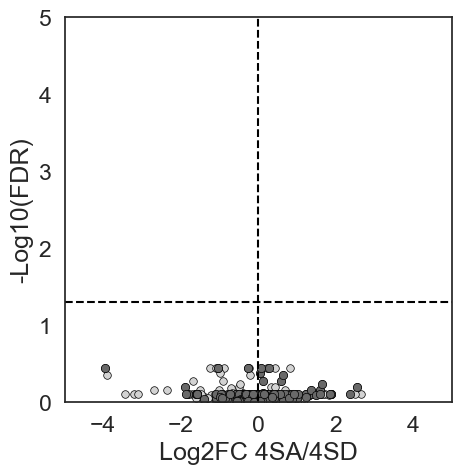

In [385]:
#Volcano plot to look at APA usage. More proximal or distal usage? 
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = df_results, x = "log2FC", y = -np.log10(df_results["FDR"]), s = 30, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.5)
sns.scatterplot(data = df_results.loc[df_results.APA_ID.str.contains("P")], x = "log2FC", y = -np.log10(df_results.loc[df_results.APA_ID.str.contains("P")]["FDR"]), color = "dimgrey", edgecolor = "black", linewidth = 0.5)

# for i in np.unique(list(df_results.Gene_Name)):
#     sns.lineplot(data = df_results.loc[df_results.Gene_Name == i], x = "log2FC", y = -np.log10(df_results.loc[df_results.Gene_Name == i]["FDR"]), color = "black", linewidth = 1, alpha = 0.5)

ax.axhline(-np.log10(0.05), color = "black", linestyle = "--")
ax.axvline(0, color = "black", linestyle = "--")
ax.set_xlim(-5, 5)
ax.set_ylim(0,5)
ax.set_xlabel("Log2FC 4SA/4SD")
ax.set_ylabel("-Log10(FDR)")


Same analysis with the long read data:

Compare EV to WT. Does overexpression of PABPN1 show reverse of KD in Cell paper?

In [348]:
#load in results DF and run the function to calculate differences in APA
data_df = pd.read_csv(path + "pau_results.txt", sep = "\t")
df_results_2 = APA_differences(data_df, "h112", "h113")

/Users/jacksongordon/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/jacksongordon/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [355]:
df_results_2.head()

,APA_ID,Transcript,Gene,Gene_Name,Chr,LastExon.Start,LastExon.End,Strand,UTR3.Start,UTR3.End,...,h115_R2_utr_quant.TPM,h115_R3_utr_quant.TPM,h117_R1_utr_quant.TPM,h117_R2_utr_quant.TPM,h117_R3_utr_quant.TPM,h112_PAU_mean,h113_PAU_mean,log2FC,pvalue,FDR
0,ENSG00000010017_1_D,ENST00000011619,ENSG00000010017,RANBP9,chr6,13621730,13622492,-,13621730,13622361,...,1214.025417,1996.105864,1685.322082,1307.987601,1692.356698,94.946000,81.201667,-0.225598,0.294318,0.642154
1,ENSG00000010017_2_D,ENST00000011619,ENSG00000010017,RANBP9,chr6,13621849,13622492,-,13621849,13622361,...,303.605232,0.000000,0.000000,0.000000,0.000000,5.054000,18.798333,1.895107,0.294318,0.642154
4,ENSG00000017797_2_D,ENST00000019317,ENSG00000017797,RALBP1,chr18,9535670,9537606,+,9535937,9537606,...,493.523541,687.991704,716.909135,579.217308,668.873560,87.415667,91.762667,0.070015,0.320025,0.642154
5,ENSG00000017797_3_D,ENST00000019317,ENSG00000017797,RALBP1,chr18,9535670,9538112,+,9535937,9538112,...,59.931201,101.869231,47.355661,37.616515,68.811540,12.584333,8.237333,-0.611380,0.320025,0.642154
6,ENSG00000031823_1_P,ENST00000034275,ENSG00000031823,RANBP3,chr19,5917326,5917653,-,5917326,5917609,...,0.000000,0.000000,176.659381,0.000000,0.000000,14.384333,23.529333,0.709962,0.596805,0.810442


Text(0, 0.5, '-Log10(FDR)')

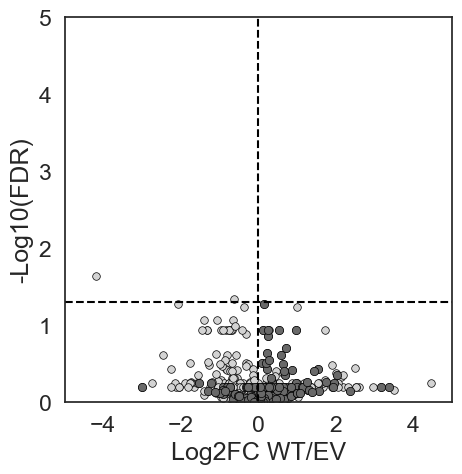

In [382]:
#Volcano plot to look at APA usage. More proximal or distal usage? EV vs WT
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = df_results_2, x = "log2FC", y = -np.log10(df_results_2["FDR"]), s = 30, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.5)

# for i in np.unique(list(df_results_2.Gene_Name)):
#     sns.lineplot(data = df_results_2.loc[df_results_2.Gene_Name == i], x = "log2FC", y = -np.log10(df_results_2.loc[df_results_2.Gene_Name == i]["FDR"]), color = "black", linewidth = 1, alpha = 0.5)

sns.scatterplot(data = df_results_2.loc[df_results_2.APA_ID.str.contains("P")], x = "log2FC", y = -np.log10(df_results_2.loc[df_results_2.APA_ID.str.contains("P")]["FDR"]), color = "dimgrey", edgecolor = "black", linewidth = 0.5)

ax.axhline(-np.log10(0.05), color = "black", linestyle = "--")
ax.axvline(0, color = "black", linestyle = "--")
ax.set_xlim(-5, 5)
ax.set_ylim(0,5)
ax.set_xlabel("Log2FC WT/EV")
ax.set_ylabel("-Log10(FDR)")


## Analyzing Long Read Sequencing

For the long read sequencing data, I can treat the data somewhat like a 3'-end seq dataset. First point to the path where the data are. 

In [10]:
#Set datapath for DESeq2 analyses
path_2 = "/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/"

First a list of genes must be annotated to assign each read to. Uncomment sections as needed.

In [222]:
# load annotation and grab all gene names
#Uncomment the line below and run ONCE to generate gffutils db file
# db = gffutils.create_db(path_2 + 'config/combined.gtf', dbfn='combined.db', force=False)

db = gffutils.FeatureDB('combined.db')
all_genes = [i[8]['gene_name'][0] for i in db.features_of_type('gene')]

# save all genes to new bed file:
with open(path_2 + 'config/all_genes.bed', 'w') as f:
    f.write('\t'.join(['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand']) + '\n')
    
    for feature in db.all_features():
        if feature[2] == 'gene' and feature[8]['gene_name'][0] in all_genes:
            f.write(str(feature[0]) + '\t')
            f.write(str(feature[3]) + '\t')
            f.write(str(feature[4]) + '\t')
            f.write(feature[8]['gene_name'][0] + '\t')
            f.write('0\t')
            f.write(feature[6] + '\n')

To determine the poly(A) sites of each read, the strandedness for each gene is needed.

In [255]:
# get strand info for all genes (e.g. plus or minus strand)
all_strands = dict(zip([i[8]['gene_name'][0] for i in db.features_of_type('gene')], [i[6] for i in db.features_of_type('gene')]))

The function below takes the bamfile (reads), intersected bed file from all genes bed file (this basically just gives each read a gene assignment), the all_strands file with strandedness info, and the allowed range between annotated PAS and observed PAS to be considered. 

In [256]:
#Define a function to find the polyA site per read
def find_pas(bamfile, bedfile, all_strands, range_3=1000):

    bam = pysam.AlignmentFile(bamfile, 'rb')
    total_reads = bam.count()
    # dict associating each read name with a gene|
    bed = pd.read_csv(bedfile, delimiter='\t', header=None, usecols=[3, 15, 5, 13, 14])
    
    read_assoc = {row[3]: [row[15], row[5], row[13], row[14]] for _, row in bed.iterrows()}
    
    # final dict associating each gene with a list of 3'-ends
    covered_genes = np.unique(bed[15])
    genes_read_ends = dict(zip(covered_genes, [[] for _ in range(len(covered_genes))]))

    for read in tqdm(bam.fetch(), total=total_reads):
        if not read.is_secondary and not read.is_supplementary and read.query_name in read_assoc:
            _, mapped_3 = read_ends(read)
            # add read end to dictionary if it falls within specified range from annotated 3'-end
            if read.is_reverse:
                annotated_3 = read_assoc[read.query_name][2]
            else:
                annotated_3 = read_assoc[read.query_name][3]

            if abs(mapped_3-annotated_3) <= range_3:
                genes_read_ends[read_assoc[read.query_name][0]].append(mapped_3)

    bam.close()
    
    return(genes_read_ends)

Intersect reads files with all_genes.bed file

In [280]:
#
import os

readfilename = [path_2 + 'results/mapping/h112.R1_hg38.bam',
                path_2 + 'results/mapping/h112.R2_hg38.bam',
                path_2 + 'results/mapping/h113.R1_hg38.bam',
                path_2 + 'results/mapping/h113.R2_hg38.bam',
                path_2 + 'results/mapping/h115.R1_hg38.bam',
                path_2 + 'results/mapping/h115.R2_hg38.bam',
                path_2 + 'results/mapping/h117.R1_hg38.bam',
                path_2 + 'results/mapping/h117.R2_hg38.bam']

bedfilename = path_2 + 'config/all_genes.bed'

outnames = [path_2 + 'results/apa/h112_R1_annP.bed',
            path_2 + 'results/apa/h112_R2_annP.bed',
            path_2 + 'results/apa/h113_R1_annP.bed',
            path_2 + 'results/apa/h113_R2_annP.bed',
            path_2 + 'results/apa/h115_R1_annP.bed',
            path_2 + 'results/apa/h115_R2_annP.bed',
            path_2 + 'results/apa/h117_R1_annP.bed',
            path_2 + 'results/apa/h117_R2_annP.bed']

for idx,i in enumerate(readfilename):
    os.system(f'bedtools intersect -bed -wo -s -f 0.25 -abam {readfilename[idx]} -b {bedfilename} > {outnames[idx]}')
    print("intersecting " + readfilename[idx] + " and " + bedfilename + " to " + outnames[idx])

***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h112.R1_hg38.bam has inconsistent naming convention for record:
GL000009.2	34651	36797	m64146_210430_195255/18284941/ccs	16	-

***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h112.R1_hg38.bam has inconsistent naming convention for record:
GL000009.2	34651	36797	m64146_210430_195255/18284941/ccs	16	-



intersecting/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h112.R1_hg38.bam and /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/all_genes.bed to /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/apa/h112_R1_annP.bed


***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h112.R2_hg38.bam has inconsistent naming convention for record:
GL000008.2	152383	153844	m64146_210812_153541/129762139/ccs	0	-

***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h112.R2_hg38.bam has inconsistent naming convention for record:
GL000008.2	152383	153844	m64146_210812_153541/129762139/ccs	0	-



intersecting/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h112.R2_hg38.bam and /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/all_genes.bed to /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/apa/h112_R2_annP.bed


***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h113.R1_hg38.bam has inconsistent naming convention for record:
GL000009.2	20590	21107	m64146_210430_195255/132056444/ccs	0	-

***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h113.R1_hg38.bam has inconsistent naming convention for record:
GL000009.2	20590	21107	m64146_210430_195255/132056444/ccs	0	-



intersecting/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h113.R1_hg38.bam and /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/all_genes.bed to /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/apa/h113_R1_annP.bed


***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h113.R2_hg38.bam has inconsistent naming convention for record:
GL000009.2	54855	124822	m64146_210812_153541/178128839/ccs	31	-

***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h113.R2_hg38.bam has inconsistent naming convention for record:
GL000009.2	54855	124822	m64146_210812_153541/178128839/ccs	31	-



intersecting/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h113.R2_hg38.bam and /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/all_genes.bed to /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/apa/h113_R2_annP.bed


***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h115.R1_hg38.bam has inconsistent naming convention for record:
GL000008.2	132747	133248	m64146_210430_195255/139332027/ccs	60	+

***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h115.R1_hg38.bam has inconsistent naming convention for record:
GL000008.2	132747	133248	m64146_210430_195255/139332027/ccs	60	+



intersecting/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h115.R1_hg38.bam and /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/all_genes.bed to /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/apa/h115_R1_annP.bed


***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h115.R2_hg38.bam has inconsistent naming convention for record:
GL000009.2	77958	124859	m64146_210812_153541/64293249/ccs	40	-

***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h115.R2_hg38.bam has inconsistent naming convention for record:
GL000009.2	77958	124859	m64146_210812_153541/64293249/ccs	40	-



intersecting/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h115.R2_hg38.bam and /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/all_genes.bed to /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/apa/h115_R2_annP.bed


***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h117.R1_hg38.bam has inconsistent naming convention for record:
GL000008.2	83396	131277	m64146_210430_195255/84609546/ccs	6	+

***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h117.R1_hg38.bam has inconsistent naming convention for record:
GL000008.2	83396	131277	m64146_210430_195255/84609546/ccs	6	+



intersecting/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h117.R1_hg38.bam and /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/all_genes.bed to /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/apa/h117_R1_annP.bed
intersecting/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h117.R2_hg38.bam and /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/all_genes.bed to /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/apa/h117_R2_annP.bed


***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h117.R2_hg38.bam has inconsistent naming convention for record:
GL000009.2	82653	124814	m64146_210812_153541/56756788/ccs	1	-

***** WARNING: File /Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/mapping/h117.R2_hg38.bam has inconsistent naming convention for record:
GL000009.2	82653	124814	m64146_210812_153541/56756788/ccs	1	-



Now run the function with each dataset

In [314]:
#Test run
pas_h112_1 = find_pas(path_2 + 'results/mapping/h112.R1_hg38.bam', path_2 + 'results/apa/h112_R1_annP.bed', all_strands, 500)
pas_h112_2 = find_pas(path_2 + 'results/mapping/h112.R2_hg38.bam', path_2 + 'results/apa/h112_R2_annP.bed', all_strands, 500)

pas_h113_1 = find_pas(path_2 + 'results/mapping/h113.R1_hg38.bam', path_2 + 'results/apa/h113_R1_annP.bed', all_strands, 500)
pas_h113_2 = find_pas(path_2 + 'results/mapping/h113.R2_hg38.bam', path_2 + 'results/apa/h113_R2_annP.bed', all_strands, 500)

pas_h115_1 = find_pas(path_2 + 'results/mapping/h115.R1_hg38.bam', path_2 + 'results/apa/h115_R1_annP.bed', all_strands, 500)
pas_h115_2 = find_pas(path_2 + 'results/mapping/h115.R2_hg38.bam', path_2 + 'results/apa/h115_R2_annP.bed', all_strands, 500)

pas_h117_1 = find_pas(path_2 + 'results/mapping/h117.R1_hg38.bam', path_2 + 'results/apa/h117_R1_annP.bed', all_strands, 500)
pas_h117_2 = find_pas(path_2 + 'results/mapping/h117.R2_hg38.bam', path_2 + 'results/apa/h117_R2_annP.bed', all_strands, 500)


100%|███████████████████████████████| 121037/121037 [00:00<00:00, 166602.45it/s]


The function below now takes the annotated poly(A) sites for each read and groups them into observed poly(A) sites. The function takes the read ends file (previous step), the strandedness for each gene, and the peak height and peak distance to be considered to group together PAS's. 

In [318]:
from scipy.signal import peak_widths
peak_align_no = 0

def meta_pas(genes_read_ends, all_strands, peak_height, peak_dist):
    # aligns all PAS at the dominant peak
    num_pas = {}
    meta_pas = np.zeros(4000)
    widths = []
    for gene, ends in genes_read_ends.items():
        if ends:
            if all_strands[gene] == '+':
                signal = np.histogram(ends, bins=np.arange(min(ends), max(ends)+1, 1))[0]
            else:
                signal = np.histogram(ends, bins=np.arange(min(ends), max(ends)+1, 1))[0][::-1]
            # find peaks in 3'-end signal
            peaks = find_peaks(signal, height=peak_height, distance=peak_dist)[0]
            # if there were peaks:
            if peaks.size > 0:
                # number of peaks
                num_pas[gene] = len(peaks)
                peak_align_no = np.argmax([signal[i] for i in peaks])
                # widths
                w = peak_widths(signal, [peaks[peak_align_no]], rel_height=0.95)[0]
                widths.append(w[0])

                # first peak should be at idx 200 of meta plot
                if peaks[peak_align_no] > 1000:
                    meta_pas += np.pad(signal[peaks[peak_align_no]-1000:], (0, len(meta_pas)-len(signal[peaks[peak_align_no]-1000:])))/np.sum(signal)
                elif peaks[peak_align_no] <= 1000:
                    meta_pas += np.pad(signal, (1000-peaks[peak_align_no], len(meta_pas)-len(signal)-(1000-peaks[peak_align_no])))/np.sum(signal)
                    
    return(meta_pas, num_pas)

Run the function above

In [322]:
#Run function
meta_pas_h112_1, num_pas_h112_1 = meta_pas(pas_h112_1, all_strands, 10, 100)
meta_pas_h112_2, num_pas_h112_2 = meta_pas(pas_h112_2, all_strands, 10, 100)

meta_pas_h113_1, num_pas_h113_1 = meta_pas(pas_h113_1, all_strands, 10, 100)
meta_pas_h113_2, num_pas_h113_2 = meta_pas(pas_h113_2, all_strands, 10, 100)

meta_pas_h115_1, num_pas_h115_1 = meta_pas(pas_h115_1, all_strands, 10, 100)
meta_pas_h115_2, num_pas_h115_2 = meta_pas(pas_h115_2, all_strands, 10, 100)

meta_pas_h117_1, num_pas_h117_1 = meta_pas(pas_h117_1, all_strands, 10, 100)
meta_pas_h117_2, num_pas_h117_2 = meta_pas(pas_h117_2, all_strands, 10, 100)

In [323]:
#Average together replicates for meta PAS
meta_pas_h112 = (meta_pas_h112_1 + meta_pas_h112_2)/2
meta_pas_h113 = (meta_pas_h113_1 + meta_pas_h113_2)/2
meta_pas_h115 = (meta_pas_h115_1 + meta_pas_h115_2)/2
meta_pas_h117 = (meta_pas_h117_1 + meta_pas_h117_2)/2


In [324]:
#Merge the two replicates of counts
num_pas_h112 = dict(num_pas_h112_1.items() & num_pas_h112_2.items())
num_pas_h113 = dict(num_pas_h113_1.items() & num_pas_h113_2.items())
num_pas_h115 = dict(num_pas_h115_1.items() & num_pas_h115_2.items())
num_pas_h117 = dict(num_pas_h117_1.items() & num_pas_h117_2.items())


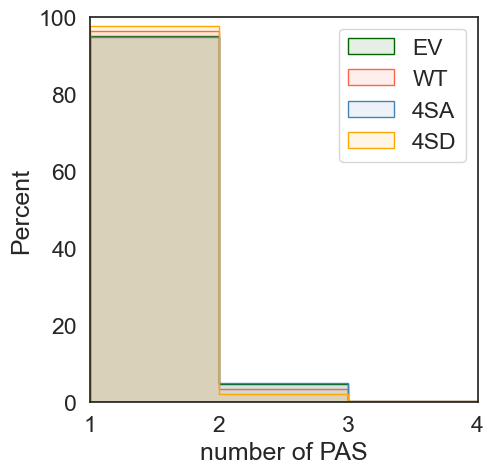

In [325]:
#Plot the number of poly(A) sites per gene 
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.histplot(list(num_pas_h112.values()), bins=np.arange(0, 10, 1), alpha=0.1, stat = 'percent', color = 'darkgreen', element = 'step', fill = True, ax = ax)
sns.histplot(list(num_pas_h113.values()), bins=np.arange(0, 10, 1), alpha=0.1, stat = 'percent', color = 'tomato', element = 'step', fill = True, ax = ax)
sns.histplot(list(num_pas_h115.values()), bins=np.arange(0, 10, 1), alpha=0.1, stat = 'percent', color = 'steelblue', element = 'step', fill = True, ax = ax)
sns.histplot(list(num_pas_h117.values()), bins=np.arange(0, 10, 1), alpha=0.1, stat = 'percent', color = 'orange', element = 'step', fill = True, ax = ax)

ax.set_ylim(0, 100)
ax.set_xlim(1,4)
ax.set_xlabel("number of PAS")
plt.legend(['EV', 'WT', '4SA', '4SD'])

1


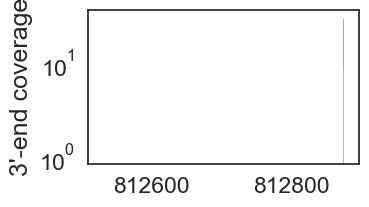

In [337]:
#Plot the peak pileup for genes of interest
test = 'RPLP2'
print(num_pas_h115[test])
fix, axs = plt.subplots(figsize=(3.5,2))
axs.hist(pas_h113_1[test], bins=np.arange(min(pas_h115_1[test]), max(pas_h115_1[test])+1, 1.5))
axs.set_yscale('log')
axs.set_ylabel("3'-end coverage")
plt.show()

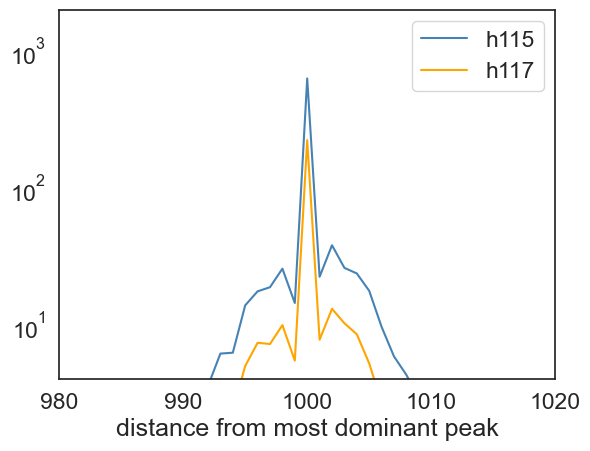

In [340]:
plt.plot(meta_pas_h115, color = "steelblue")
plt.plot(meta_pas_h117, color = "orange")
plt.xlim([980, 1020])
plt.ylim([4, 2000])
plt.yscale('log')
plt.legend(['h115', 'h117'])
plt.xlabel('distance from most dominant peak')
# plt.savefig('figs/PAS_meta.pdf')
plt.show()

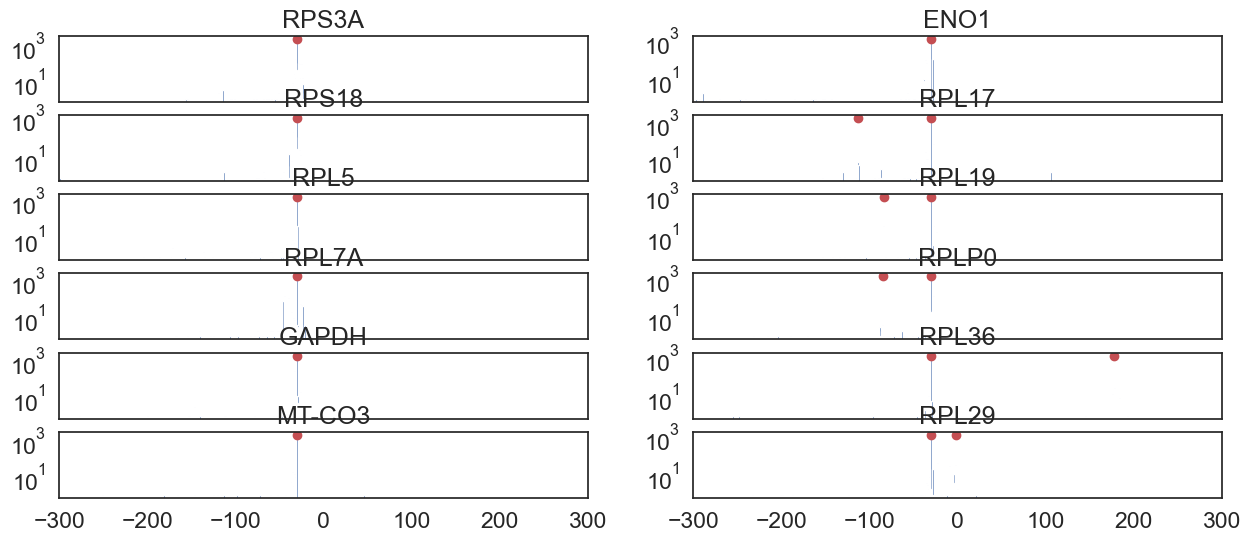

In [341]:
# plot signal for some highly-covered genes
peak_height = 4
peak_dist = 18
top = 6 # number of top genes to plot

# find genes with the most signal
top_1000 = np.argsort([len(ends) for _, ends in pas_h113_1.items()])[::-1][:1000]
top_1000 = [list(pas_h113_1.keys())[i] for i in top_1000]


fig, axs = plt.subplots(top, 2, figsize=(15, top), sharex=True)

meta_pas_v2 = np.zeros([top, 2000])

i = 0
m = 0
n = 0
while n < top or m < top:
# for i, gene in enumerate(top_10):
    i += 1
    gene = top_1000[i]
    ends = pas_h113_1[gene]
    if all_strands[gene] == '+':
        signal = np.histogram(ends, bins=np.arange(min(ends), max(ends)+1, 1))[0]
    else:
        signal = np.histogram(ends, bins=np.arange(min(ends), max(ends)+1, 1))[0][::-1]
    # find peaks in 3'-end signal
    peaks = find_peaks(signal, height=peak_height, distance=peak_dist)[0]
    # find most dominant peak
    if peaks.size == 1 and n < top:
        preferred = np.argmax([signal[i] for i in peaks])
        # plot and align at most dominant peak
        axs[n, 0].bar(np.arange(0, len(signal))-peaks[preferred]-30, signal, 1.5)
        axs[n, 0].set_title(gene)
#         meta_pas_v2[i, 1000-peaks[preferred]:len(signal)+1000-peaks[preferred]] += (signal-np.mean(signal))/np.std(signal)
        for peak in peaks:
            axs[n, 0].plot(peak-peaks[preferred]-30, max(signal), 'or')
        n += 1
    elif peaks.size == 2 and m < top:
        preferred = np.argmax([signal[i] for i in peaks])
        # plot and align at most dominant peak
        axs[m, 1].bar(np.arange(0, len(signal))-peaks[preferred]-30, signal, 1.5)
        axs[m, 1].set_title(gene)
#         meta_pas_v2[i, 1000-peaks[preferred]:len(signal)+1000-peaks[preferred]] += (signal-np.mean(signal))/np.std(signal)
        for peak in peaks:
            axs[m, 1].plot(peak-peaks[preferred]-30, max(signal), 'or')
        m += 1

plt.setp(axs, yscale='log', xlim=[-300, 300])

# plt.savefig('figs/multi_PAS_examples.pdf')
plt.show()